In [1]:
# Theme-Corpus Similarity Analysis
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# import tensorflow as tf
# import tensorflow_hub as hub

c:\Users\Akhil PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:

# Load the model
# model = SentenceTransformer('all-MiniLM-L6-v2')
model = SentenceTransformer('all-MiniLM-L12-v2')
# model = SentenceTransformer('BAAI/bge-large-en-v1.5')

In [20]:

# Load the Excel files
theme_df = pd.read_excel(r"C:\Users\Akhil PC\Documents\internships\SPJIMR - Internship\methodology paper\CSR.xlsx")
corpus_df = pd.read_excel(r"C:\Users\Akhil PC\Documents\internships\SPJIMR - Internship\methodology paper\sentences.xlsx")

corpus_df.head()

,company,sentence,label
0,Sun Pharma,The Company’s CSR policy encompasses the compa...,CSR 1 - General
1,Sun Pharma,Sun Pharma is committed to making a positive i...,CSR 1 - General
2,Sun Pharma,The company has contributed ₹100.00 Million du...,CSR 6 - Community
3,Sun Pharma,The project has been undertaken to set up a la...,CSR 5 - Products
4,Sun Pharma,The project aims to provide access to safe and...,CSR 6 - Community


In [21]:
## all unique labels

corpus_df['label'].unique()

array(['CSR 1 - General', 'CSR 6 - Community', 'CSR 5 - Products',
       'CSR 2 - Environmental', 'CSR 3 - Energy',
       'CSR 4 - Human Resources', 'CSR 7 - Fair Business Practices'],
      dtype=object)

In [22]:
# Clean the label column by removing "CSR n - " prefix
corpus_df['label'] = corpus_df['label'].str.replace(r'CSR \d+ - ', '', regex=True)

# Verify the unique values in the cleaned label column
corpus_df['label'].unique()

array(['General', 'Community', 'Products', 'Environmental', 'Energy',
       'Human Resources', 'Fair Business Practices'], dtype=object)

In [23]:
theme_df.head(7)

,CSR Measuring Instrument,Description,Example Sentences
0,General,The gneral CSR paradigm establishes the core f...,Acknowledgment or management of corporate soci...
1,Environmental,The environmental paradigm evaluates how a com...,Undertaking environmental impact studies & mon...
2,Energy,This paradigm focuses on a company’s initiativ...,Disclosing the company’s efforts to reduce ene...
3,Human Resources,The human resources paradigm examines the comp...,Promotion of employee well-being/health & safe...
4,Products,"This paradigm assesses the safety, quality, an...",Making products safer (Quality Control)/Produc...
5,Community,The community paradigm measures how companies ...,"Community relationships, consultation, develop..."
6,Fair Business Practices,This paradigm evaluates the ethical and transp...,Socially responsible practices abroad/Support ...


In [24]:
# Process theme data
theme_data = []
for idx, row in theme_df.iterrows():
    instrument = row['CSR Measuring Instrument']
    sentences = row['Example Sentences'].split(';')
    for sentence in sentences:
        sentence = sentence.strip()
        if sentence:  # Skip empty sentences
            theme_data.append({
                'label': instrument,
                'sentence': sentence
            })

theme_processed_df = pd.DataFrame(theme_data)
theme_processed_df.head()

,label,sentence
0,General,Acknowledgment or management of corporate soci...
1,General,Disclosure of corporate objectives or policies...
2,Environmental,Undertaking environmental impact studies & mon...
3,Environmental,Disclosure of (reportable) environmental incid...
4,Environmental,Conducting environmental (compliance) audits


In [25]:
# Generate embeddings for theme sentences
theme_embeddings = model.encode(theme_processed_df['sentence'].tolist())
theme_processed_df['embedding'] = list(theme_embeddings)


# Generate embeddings for corpus sentences
corpus_embeddings = model.encode(corpus_df['sentence'].tolist())
corpus_df['embedding'] = list(corpus_embeddings)

In [30]:
# Set threshold for cosine similarity
SIMILARITY_THRESHOLD = 0.55

# Matching algorithm
def find_best_match(embedding, threshold=SIMILARITY_THRESHOLD):
    similarities = cosine_similarity([embedding], theme_embeddings)[0]
    max_similarity_idx = np.argmax(similarities)
    max_similarity = similarities[max_similarity_idx]
    
    if max_similarity >= threshold:
        return theme_processed_df.iloc[max_similarity_idx]['label'], max_similarity
    else:
        return "unmatched", max_similarity

# Apply matching algorithm to corpus
results = []
for idx, row in corpus_df.iterrows():
    pred_label, similarity = find_best_match(row['embedding'])
    results.append({
        'company': row['company'],
        'sentence': row['sentence'],
        'true_label': row['label'],
        'predicted_label': pred_label,
        'similarity_score': similarity
    })

# Create results dataframe
results_df = pd.DataFrame(results)

In [36]:
results_df.head()

,company,sentence,true_label,predicted_label,similarity_score
0,Sun Pharma,The Company’s CSR policy encompasses the compa...,General,General,0.704646
1,Sun Pharma,Sun Pharma is committed to making a positive i...,General,unmatched,0.395777
2,Sun Pharma,The company has contributed ₹100.00 Million du...,Community,unmatched,0.316328
3,Sun Pharma,The project has been undertaken to set up a la...,Products,unmatched,0.327805
4,Sun Pharma,The project aims to provide access to safe and...,Community,unmatched,0.514295


Overall accuracy: 0.9355
Precision: 0.9570
Recall: 0.9355
F1 Score: 0.9339


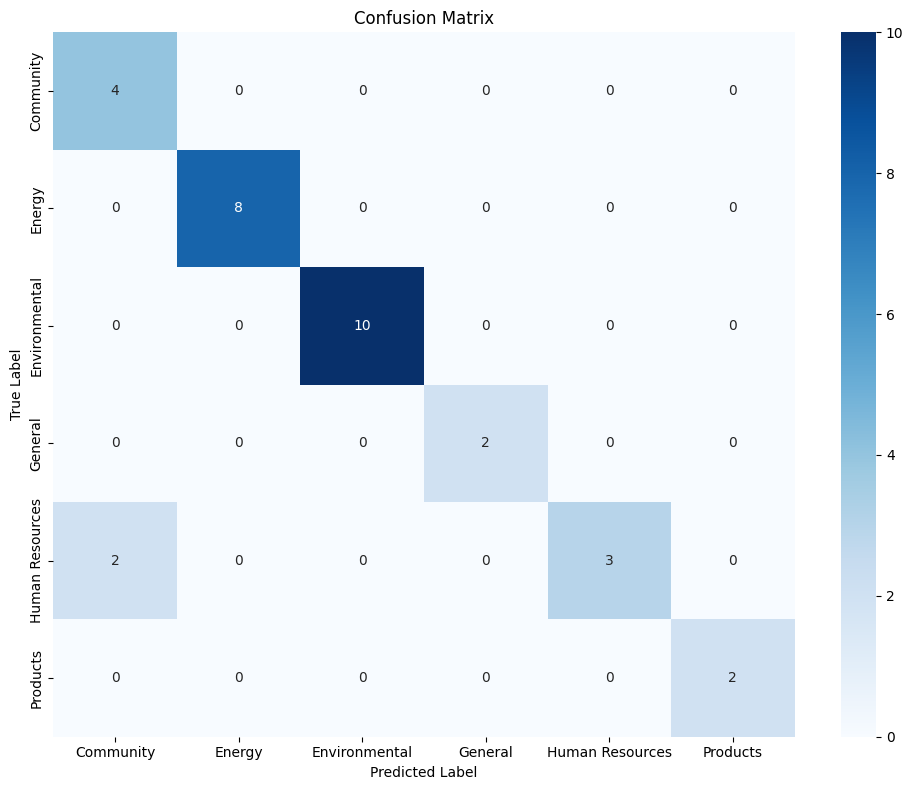

In [32]:
# Calculate metrics
# Filter out unmatched for metric calculation
matched_df = results_df[results_df['predicted_label'] != 'unmatched']
if not matched_df.empty:
    accuracy = accuracy_score(matched_df['true_label'], matched_df['predicted_label'])
    precision, recall, f1, _ = precision_recall_fscore_support(
        matched_df['true_label'], 
        matched_df['predicted_label'], 
        average='weighted',
        zero_division=0
    )
    
    # Create confusion matrix
    labels = sorted(set(matched_df['true_label'].unique()) | set(matched_df['predicted_label'].unique()))
    cm = confusion_matrix(
        matched_df['true_label'], 
        matched_df['predicted_label'],
        labels=labels
    )
    
    # Display metrics
    print(f"Overall accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
else:
    print("No matched samples to calculate metrics")

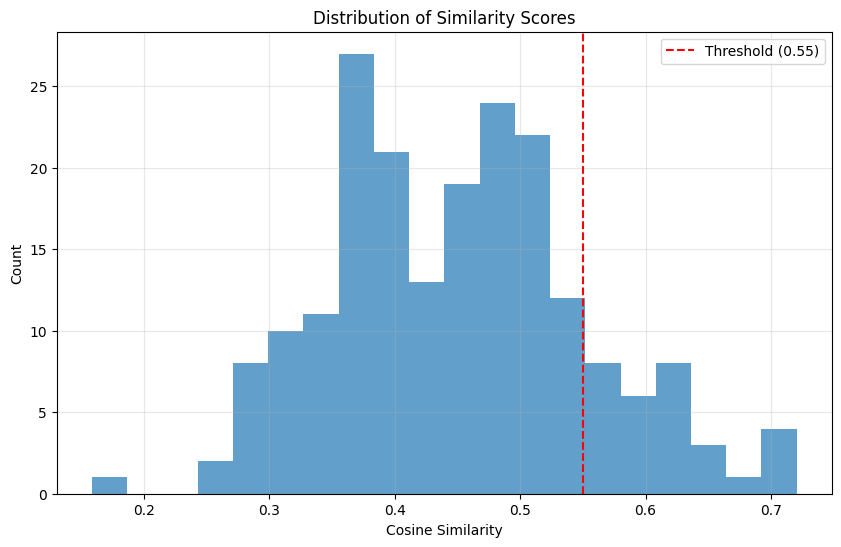

In [33]:
# Distribution of similarity scores
plt.figure(figsize=(10, 6))
plt.hist(results_df['similarity_score'], bins=20, alpha=0.7)
plt.axvline(x=SIMILARITY_THRESHOLD, color='r', linestyle='--', label=f'Threshold ({SIMILARITY_THRESHOLD})')
plt.title('Distribution of Similarity Scores')
plt.xlabel('Cosine Similarity')
plt.ylabel('Count')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [37]:
# Extract top 5 matching sentences for each CSR category
categories = theme_processed_df['label'].unique()

# Create a nice formatted display of results
print("# Top 5 Matching Sentences for Each CSR Category\n")

for category in categories:
    # Filter results for this category
    category_matches = results_df[results_df['predicted_label'] == category]
    
    # Sort by similarity score in descending order and take top 5
    top_matches = category_matches.sort_values('similarity_score', ascending=False).head(5)
    
    print(f"## {category}")
    print("-" * 80)
    
    if len(top_matches) > 0:
        for i, (_, row) in enumerate(top_matches.iterrows(), 1):
            print(f"**{i}. Score: {row['similarity_score']:.3f} - {row['company']}**")
            print(f"Sentence: \"{row['sentence']}\"\n")
    else:
        print("No matches found.\n")
    
    print("\n")

# Top 5 Matching Sentences for Each CSR Category

## General
--------------------------------------------------------------------------------
**1. Score: 0.705 - Sun Pharma**
Sentence: "The Company’s CSR policy encompasses the company’s philosophy towards corporate social responsibility and lays down the guidelines and mechanism for undertaking socially useful programs for welfare & sustainable development of the community at large."

**2. Score: 0.697 - UltraTech Cement**
Sentence: "The Company’s Corporate Social Responsibility ('CSR') policy conforms to the National Voluntary Guidelines on Social, Environment and Economic Responsibilities of Business released by the Ministry of Corporate Affairs, Government of India."



## Environmental
--------------------------------------------------------------------------------
**1. Score: 0.641 - Reliance Industries Ltd**
Sentence: "Promoting Sustainable Environment, Arts and Culture includes ensuring environmental sustainability, ecological b